<a href="https://colab.research.google.com/github/virgiawan/yog2a-melanoma/blob/master/SKIN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Melanoma

## 1. Preparation

In [1]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yusufmukti","key":"6fb203edd3d11b629bb80ca825c4f423"}'}

In [8]:
# CODE: enabling import data from kaggle
# Install kaggle library 
!pip install -q kaggle
# Make ".kaggle" directory in root directory
!mkdir -p ~/.kaggle
# Copy the API token to the kaggle directory
!cp kaggle.json ~/.kaggle/
# Check the directory
!ls ~/.kaggle
# Adjust access permissions
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [12]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d .
!ls

100% 5.20G/5.20G [02:13<00:00, 47.5MB/s]
100% 5.20G/5.20G [02:13<00:00, 41.8MB/s]
ham10000_images_part_1	HAM10000_metadata.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_1	hmnist_28_28_L.csv     kaggle.json
ham10000_images_part_2	hmnist_28_28_RGB.csv   sample_data
HAM10000_images_part_2	hmnist_8_8_L.csv       skin-cancer-mnist-ham10000.zip


In [0]:
meta_file = 'HAM10000_metadata.csv'
bw_file = 'hmnist_28_28_L.csv'        # black white dataset
rgb_file = 'hmnist_28_28_RGB.csv'     # rgb dataset

In [0]:
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pandas import DataFrame

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [17]:
# BLACK and WHITE extract pixel and labels from csv
with open(bw_file, newline='') as opened_file: #images
  reader = csv.reader(opened_file)
  bw_images_dataset=[]
  for row in reader:
    img = row[0:784]
    img2d = np.array_split(img,28)
    bw_images_dataset.append(img2d)
  bw_images_dataset = bw_images_dataset[1:]
  bw_images_dataset = np.array(bw_images_dataset, dtype=np.int)

with open(bw_file, newline='') as opened_file: #labels
  reader = csv.reader(opened_file)
  bw_labels_dataset = []
  for row in reader:
      label=row[784]
      bw_labels_dataset.append(label)
  bw_labels_dataset = bw_labels_dataset[1:]
  bw_labels_dataset = np.array(bw_labels_dataset, dtype=np.int)
  bw_labels = bw_labels_dataset

# 10015 images, 28x28 dimension, BW
print(bw_images_dataset.shape)
print(bw_labels.shape)

(10015, 28, 28)
(10015,)


In [18]:
# RGB extract pixel and labels from csv
with open(rgb_file, newline='') as opened_file: #images
  reader = csv.reader(opened_file)
  rgb_images_dataset=[]
  for row in reader:
    r=np.array(row[0:784])
    g=np.array(row[784:1568])
    b=np.array(row[1568:2352])
    R = np.array_split(r,28)
    G = np.array_split(r,28)
    B = np.array_split(r,28)
    image = np.dstack((R,G,B))
    rgb_images_dataset.append(image)
  rgb_images_dataset = rgb_images_dataset[1:]
  rgb_images_dataset = np.array(rgb_images_dataset, dtype=np.int)

with open(bw_file, newline='') as opened_file: #labels
  reader = csv.reader(opened_file)
  rgb_labels_dataset = []
  for row in reader:
      label=row[784]
      rgb_labels_dataset.append(label)
  rgb_labels_dataset = rgb_labels_dataset[1:]
  rgb_labels_dataset = np.array(rgb_labels_dataset, dtype=np.int)
  rgb_labels = rgb_labels_dataset

# 10015 images, 28x28 dimension, RGB
print(rgb_images_dataset.shape)
print(rgb_labels.shape)

(10015, 28, 28, 3)
(10015,)


In [0]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
df = pd.read_csv('HAM10000_metadata.csv')
# To display the top 5 rows


In [0]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [63]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


In [64]:
df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [0]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [56]:
df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [57]:
print(df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


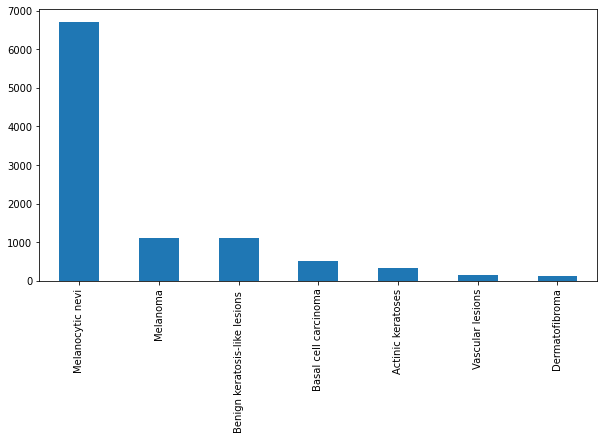

In [58]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [65]:
df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [67]:
df.groupby('cell_type').nunique()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
cell_type,,,,,,,,,,
Actinic keratoses,228,327,1,1,11,2,11,0,1,1
Basal cell carcinoma,327,514,1,1,14,2,12,0,1,1
Benign keratosis-like lesions,727,1099,1,3,14,3,14,0,1,1
Dermatofibroma,73,115,1,2,12,2,6,0,1,1
Melanocytic nevi,5403,6705,1,3,18,3,15,0,1,1
Melanoma,614,1113,1,1,15,2,13,0,1,1
Vascular lesions,98,142,1,2,18,2,10,0,1,1


In [68]:
df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [0]:
not_melanoma = df[df['cell_type']!='Melanoma']
melanoma = df[df['cell_type']=='Melanoma']

In [0]:
sum_not_melanoma = not_melanoma['cell_type'].value_counts().sum()

In [77]:
np.round(not_melanoma['cell_type'].value_counts() / sum_not_melanoma * 1200)

Melanocytic nevi                  904.0
Benign keratosis-like lesions     148.0
Basal cell carcinoma               69.0
Actinic keratoses                  44.0
Vascular lesions                   19.0
Dermatofibroma                     16.0
Name: cell_type, dtype: float64